# ARIMA

Trying ARIMA anlysis on stock market data

data should be stationary which the stock market data is not, so we must transform the data by differencing

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [71]:
# import the data
filepath = '../../data/SPY_1993-01-29_2022-08-17.csv'
data = pd.read_csv(filepath)

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.438103,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.619028,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.673309,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.944679,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.053232,531500


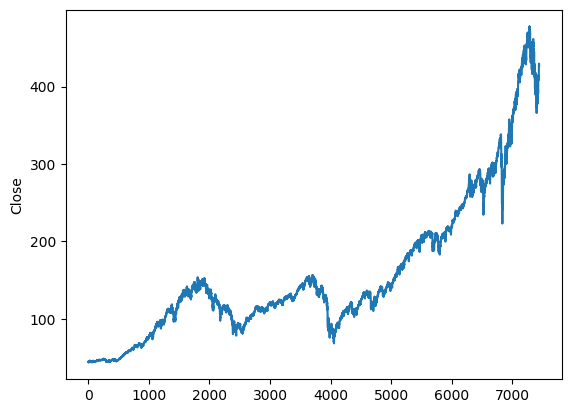

In [72]:
sns.lineplot(data=data['Close']);

In [73]:
dataset = data[['Date', 'Close']]
dataset['Date'] = pd.to_datetime(dataset['Date'])
print(dataset['Date'].dtypes)
dataset = dataset.set_index('Date', )
dataset

datetime64[ns]


C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close
Date,
1993-01-29,43.937500
1993-02-01,44.250000
1993-02-02,44.343750
1993-02-03,44.812500
1993-02-04,45.000000
...,...
2022-08-11,419.989990
2022-08-12,427.100006
2022-08-15,428.859985


checking some seasonal decompositions

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset, model='multiplicative',period=365 )

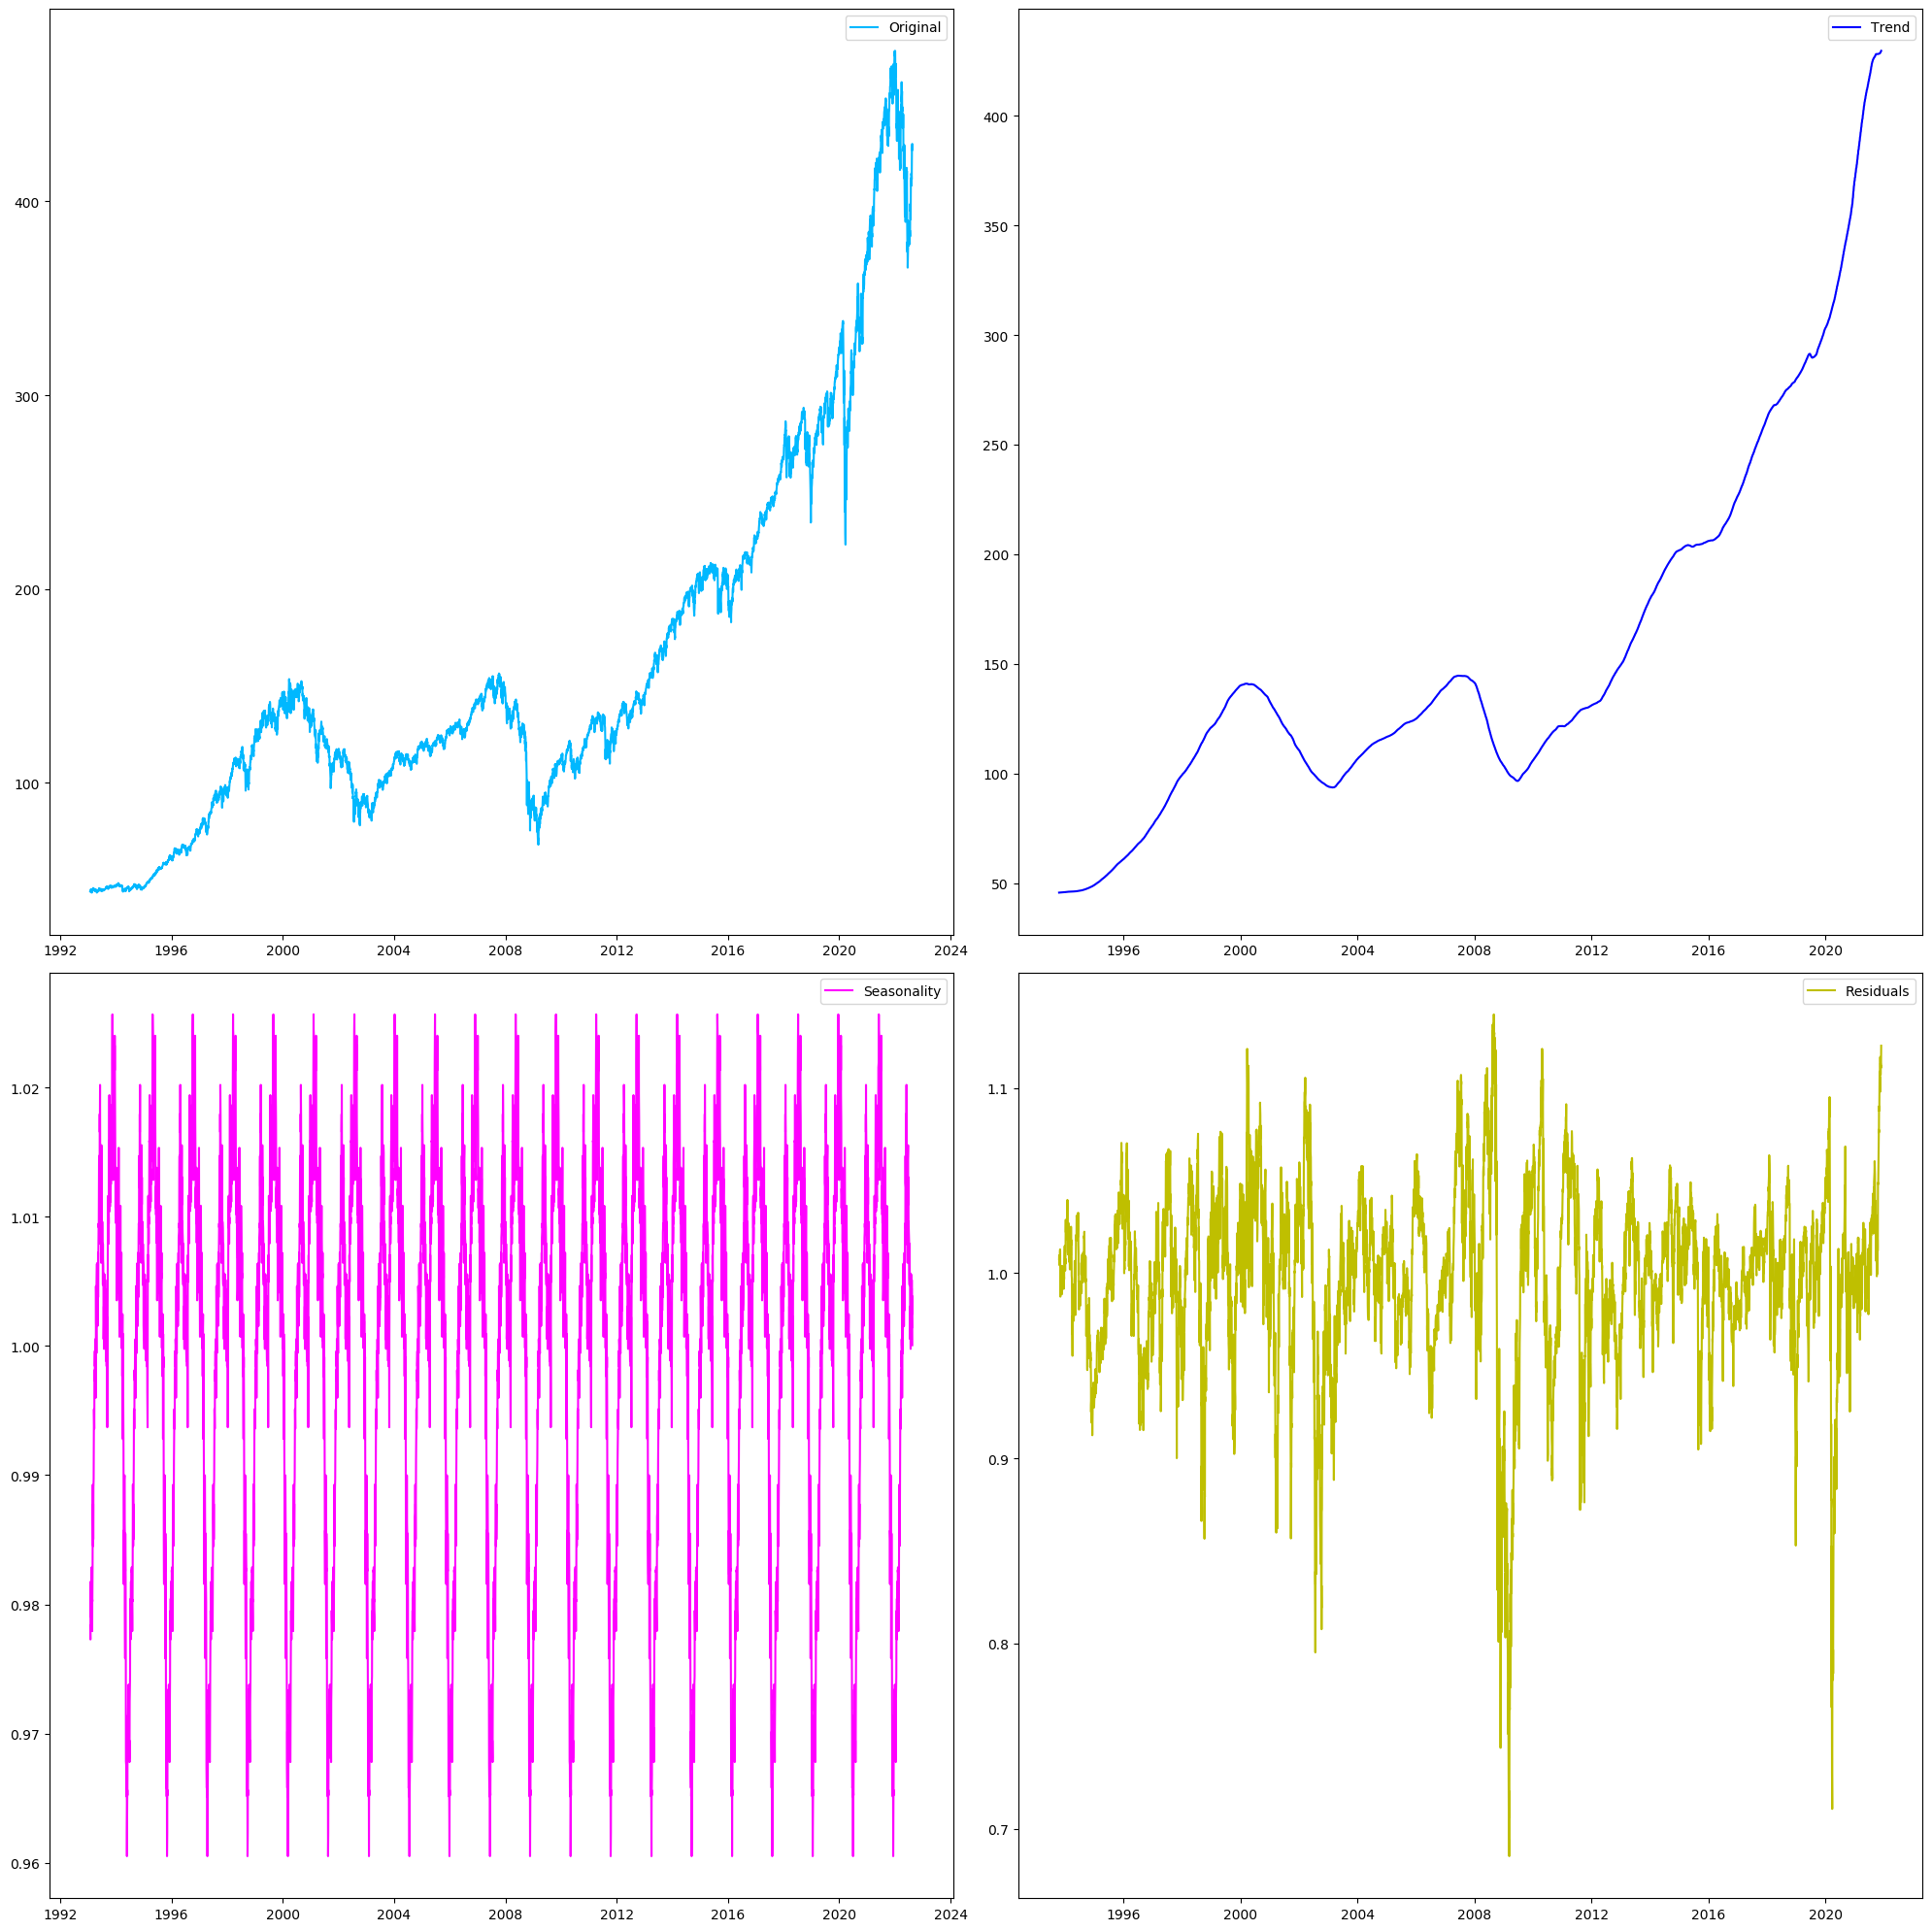

In [75]:
plt.figure(figsize=(20,20))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(221)
plt.plot(dataset, color='#00b8ff', label='Original')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend, 'b', label='Trend')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(seasonal, color = '#ff00ff', label='Seasonality')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(residual, 'y', label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show();

In [76]:
from pmdarima.arima.stationarity import ADFTest
adf_test = ADFTest(alpha=.05)
adf_test.should_diff(dataset)

(0.9751854723235325, True)

Because our data is non-stationary, we need to difference the data to get stationarity.

In [77]:
adf_test = ADFTest(alpha=.05)
adf_test.should_diff(dataset.diff()[1:])

(0.01, False)

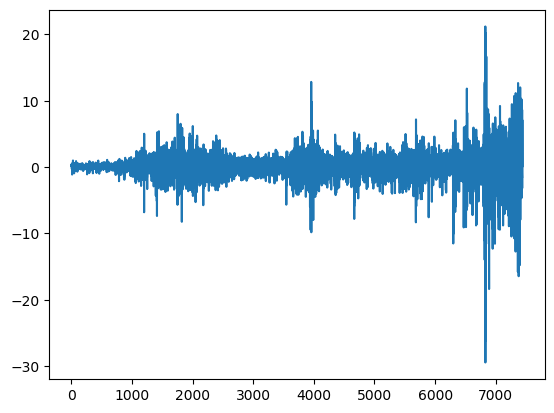

In [78]:
data['Close'].diff().plot();

The average and standard deviation seem to be moving over time, I will log the data to minimize the effects

Split testing and training data 80:20 split

In [79]:
train = np.log(dataset['Close'][:int(len(data)*.8)])
test = np.log(dataset['Close'][int(len(data)*.8):])

### Will try ARIMA on diffed data and log-diffed data

In [80]:
from pmdarima import auto_arima
arima_model = auto_arima(train, start_p=0, start_q=0,
                        test='adf',
                        max_p=8, max_q=8,
                        m=1,
                        d=None,
                        seasonal=False,
                        start_P=0,
                        D=0,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35909.519, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35929.985, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-35932.753, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35908.530, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-35949.757, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35946.654, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-35948.397, Time=1.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-35949.212, Time=1.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35947.851, Time=0.62 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-35947.809, Time=2.80 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-35947.335, Time=0.39 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 9.182 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

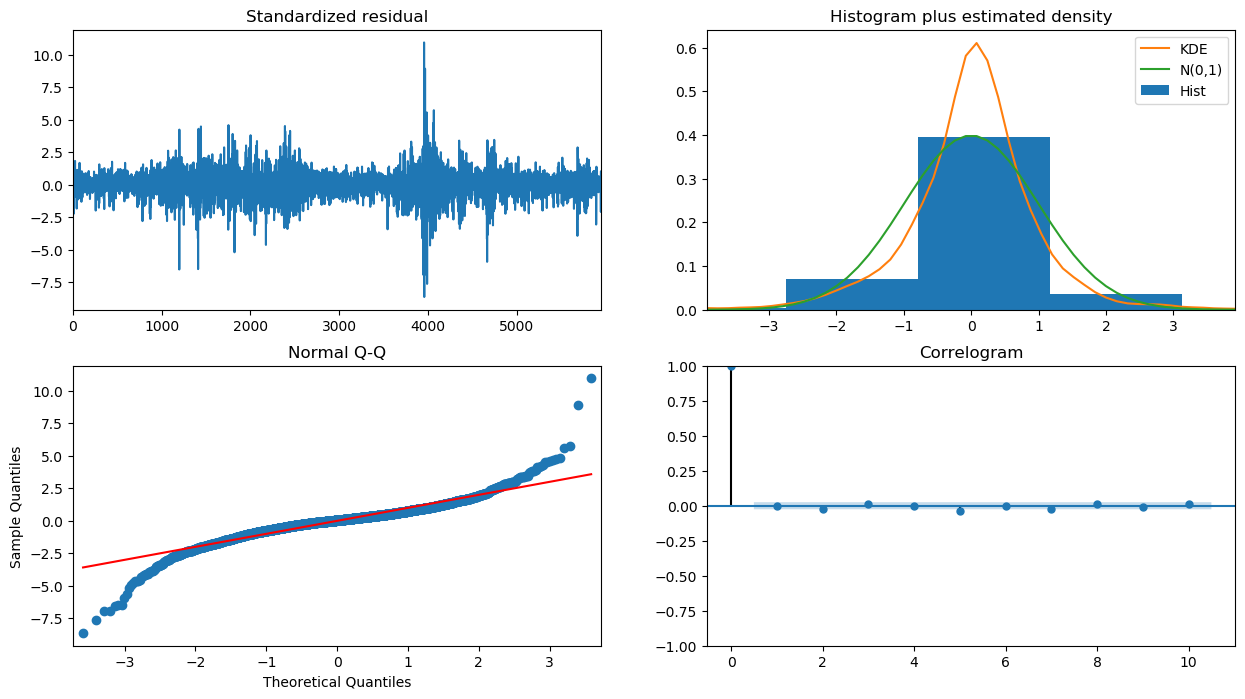

In [81]:
arima_model.plot_diagnostics(figsize=(15,8))
plt.show();

#### Best parameters according to auto-ARIMA are (1,1,1)

In [82]:
from statsmodels.tsa.arima.model import ARIMA
# Build the model and fit it using the hyper parameters
model = ARIMA(train, order=(1,1,1))
fitted = model.fit()
print(fitted.summary())

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5953
Model:                 ARIMA(1, 1, 1)   Log Likelihood               17976.667
Date:                Thu, 15 Sep 2022   AIC                         -35947.335
Time:                        16:06:13   BIC                         -35927.260
Sample:                             0   HQIC                        -35940.361
                               - 5953                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5033      0.069      7.268      0.000       0.368       0.639
ma.L1         -0.5682      0.064     -8.841      0.000      -0.694      -0.442
sigma2         0.0001   1.13e-06    123.382      0.0

In [83]:
# now we can forcast the data
result = fitted.get_forecast(len(test), alpha=.05)
fc = result.predicted_mean
conf = result.conf_int(alpha=.05)

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


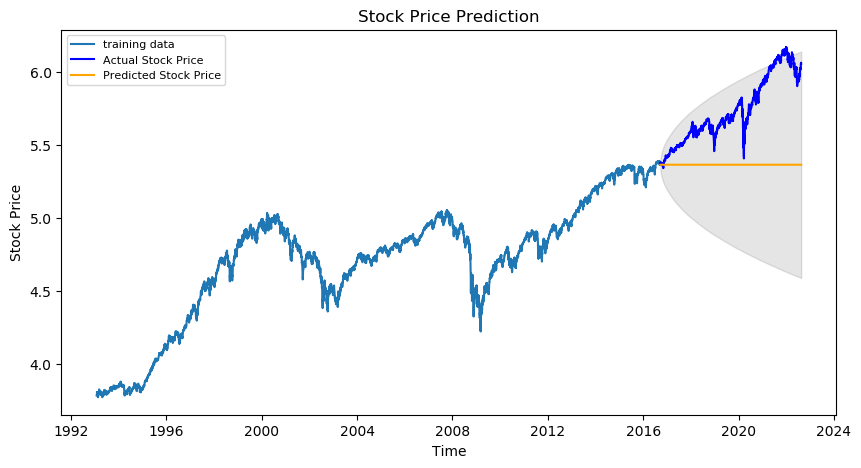

In [84]:
# Make as pandas series
fc_series = fc.set_axis(test.index)
lower_series = conf[:]['lower Close'].set_axis(test.index)
upper_series = conf[:]['upper Close'].set_axis(test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
fc = fc_series
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 0.19037578599124935
MAE: 0.37489255492070095
RMSE: 0.4363207375214354
MAPE: 0.06392863744339058


Not the greatest results in terms uf usability. will try it on Amazon data to see if there is any noticable difference